In [1]:
import scipy.io as spio
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time
from pprint import pprint
import statistics

import xgboost as xgb
from xgboost import XGBRanker
from sklearn.model_selection import ParameterGrid
import xgbfir

from sklearn.metrics import roc_curve, roc_auc_score, auc, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, log_loss, f1_score, brier_score_loss
from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from time import sleep
from tqdm import tqdm
import scipy.stats as stats
from sklearn.inspection import permutation_importance

Define number of folds (k), create some labels for later

In [2]:
k = 5
foldLabels = []
for i in range(k):
    foldLabels.append('fold '+str(i+1))
foldLabels.append('mean')

Define a few functions for extracting features (mean and slope of signals)

In [3]:
def slope(signal):
    x=np.array(range(len(signal)))
    res = stats.linregress(x, signal)
    return res[0]

def featureExtraction(X):
    X_mean = X.applymap(statistics.mean)
    X_mean.columns = [col +'_mean' for col in X.columns]
    X_slope = X.applymap(slope)
    X_slope.columns = [col +'_slope' for col in X.columns]
    return pd.concat([X_mean, X_slope], axis=1)

Next we will load our pre-processed data (in matlab .mat format), already in 5 folds with train, test, and validation set within each fold. Note that we did not use a validation set and so it is combined it with the training set. Then we will use our feature extraction methods and save these dataframes.

In [311]:
for i in tqdm(range(k)):
    #LOAD DATA
    xTrain = spio.loadmat('xTrain'+str(i+1)+'.mat',squeeze_me = True)
    xTrain = xTrain['xTrain']
    xTest = spio.loadmat('xTest'+str(i+1)+'.mat',squeeze_me = True)
    xTest = xTest['xTest']
    xVal = spio.loadmat('xVal'+str(i+1)+'.mat',squeeze_me = True)
    xVal = xVal['xVal']
    
    #convert to dataFrames
    xTrain = pd.DataFrame(xTrain)
    xTest = pd.DataFrame(xTest)
    xVal =  pd.DataFrame(xVal)

    
    #add column names
    columnNames = ['cci','etco2','eto2','fio2','hr','mac','map','spo2','z_sham']
    xTrain.columns=columnNames
    xTest.columns=columnNames
    xVal.columns=columnNames
    
    #remove previously created sham variable (add back later as single feature not "time" series)
    xTrain = xTrain.drop(columns=['z_sham'])
    xTest = xTest.drop(columns=['z_sham'])
    xVal = xVal.drop(columns=['z_sham'])
   
    #extract features
    xTrain_transform = featureExtraction(xTrain)
    xTest_transform = featureExtraction(xTest)
    xVal_transform = featureExtraction(xVal)
     
    #save train features extracted
    compression_opts = dict(method='zip', archive_name='train_features_custom_'+str(i+1)+'.csv')  
    xTrain_transform.to_csv('train_features_custom_'+str(i+1)+'.zip', index=False, compression=compression_opts)  
    #save test features extracted
    compression_opts = dict(method='zip', archive_name='test_features_custom_'+str(i+1)+'.csv')  
    xTest_transform.to_csv('test_features_custom_'+str(i+1)+'.zip', index=False, compression=compression_opts) 
    #save val features extracted
    compression_opts = dict(method='zip', archive_name='val_features_custom_'+str(i+1)+'.csv')  
    xVal_transform.to_csv('val_features_custom_'+str(i+1)+'.zip', index=False, compression=compression_opts)  

100%|█████████████████████████████████████████████| 5/5 [03:11<00:00, 38.33s/it]


Now we will move towards the training and tuning of the classifier. First we will define some monotonic constraints (see https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html).

In [3]:
#downsloping label is 1, upsloping label is 0; i.e. anything that should cause increase in rso2 with increasing value should be set to -1
constraints ={
    "etco2_mean":-1,
    "etco2_slope":-1,    
    "eto2_mean":-1,
    "eto2_slope":-1,
    "map_mean":-1,
   # "map_slope":-1,   
    "mac_mean":-1,
    #"mac_slope":-1,  
   # "cci_mean":-1,
    "cci_slope":-1,
    #"spo2_mean":-1,
    "spo2_slope":-1, 
    #"fio2_mean":-1,
    #"fio2_slope":-1,    
   # "hr_mean":-1,
    "hr_slope":-1,
}

To train and tune the model we will define some hyperparameters (and some relevant ranges) and then place them in a ParameterGrid (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) to carry out a search for the optimal set. The approach is based on Aarshay Jain's recommended approach (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/): 
1. Start with reasonable starting points (i.e. max_depth = 5, min_child_weight = 1, gamma = 0, subsample, colsample_bytree = 0.8, learning_rate = 0.1), tune n_estimators
2. Tune max_depth & min_child_weight by searching over range of combinations and maximizing metric of choice (accuracy in this case)
3. Tune gamma
4. Tune subsample and colsample_bytree
5. Tune regularization parameters alpha & lambda to prevent over-fitting
6. Reduce and optimize learning rate, re-tune n_estimators

Essentially the next 2 cells are ran and modified in an iterative fashion using the approach above.

In [23]:
n_estimators =[int(x) for x in np.linspace(100,1000, num = 10)]

max_depth =[int(x) for x in np.linspace(6, 8, num = 2)]

min_child_weight=[int(x) for x in np.linspace(1, 6, num = 6)]

gamma = [float(x) for x in np.linspace(0, 0.5, num = 6)]
reg_alpha=[float(x) for x in np.linspace(0, 0.2, num = 5)]
reg_lambda=[float(x) for x in np.linspace(0, 0.2, num = 5)]

colsample_bytree= [float(x) for x in np.linspace(0.8,1.0, num = 3)]
subsample=[float(x) for x in np.linspace(0.8,1.0, num = 3)]

learning_rate = [0.08,0.09,0.1,0.11,0.12,0.13]#[float(x) for x in np.linspace(0.01, 1, num = 5)]

#param_grid = {'n_esimators':n_esimators,'max_depth':max_depth,'min_child_weight':min_child_weight,'gamma':gamma,'reg_alpha':reg_alpha,'reg_lambda':reg_lambda}
param_grid = {'n_estimators':n_estimators}#,'learning_rate':learning_rate, 'max_depth':max_depth,'min_child_weight':min_child_weight,'gamma':gamma,'reg_alpha':reg_alpha,'reg_lambda':reg_lambda,'colsample_bytree':colsample_bytree,'subsample':subsample}

params = list(ParameterGrid(param_grid))
#print number of parameter combinations to ensure it is not excessively high (exhaustive search so can take a long time)
len(params)

10

After we have defined our hyperparameters and the combinations to search over, the cell below can be ran to search over every combination and display the best combination by each metric (AUC-ROC, accuracy, brier score, F1 score - each averaged over the number of folds).

*NOTE that when the classifier is defined the parameters that are being tuned should be removed from the definition, and those that are being held static should be defined as such.

In [24]:
#define some lists for performance metrics
aucs = []; accuracies = []; briers = [];f1s = []

for paramSet in tqdm(params):    
    #MODIFY CLASSIFER BASED ON PARAMETERS TO TUNE
    clf = XGBClassifier(use_label_encoder=False,random_state=0,learning_rate=0.1, max_depth=6,min_child_weight=5,gamma=0.1,colsample_bytree=0.8,subsample=0.8, reg_alpha=0.1,reg_lambda=0.2,**paramSet,monotone_constraints=constraints,tree_method="hist")
    
    auc_cvs = []
    accuracy_cvs=[]
    brier_score_cvs=[]
    f1_score_cvs=[]
    for i in range(k):
        #open
        yTrain = spio.loadmat('yTrain'+str(i+1)+'.mat',squeeze_me = True)
        yTrain = yTrain['yTrain']
        yTest = spio.loadmat('yTest'+str(i+1)+'.mat',squeeze_me = True)
        yTest = yTest['yTest']
        yVal = spio.loadmat('yVal'+str(i+1)+'.mat',squeeze_me = True)
        yVal = yVal['yVal']
        xTrain_transform = pd.read_csv('train_features_custom_'+str(i+1)+'.zip')
        xTest_transform = pd.read_csv('test_features_custom_'+str(i+1)+'.zip')
        xVal_transform = pd.read_csv('val_features_custom_'+str(i+1)+'.zip')
        
        #combine training and validation sets for x and y   
        xTrain_transform = pd.concat([xTrain_transform, xVal_transform])
        yTrain = np.concatenate((yTrain, yVal))
        
        #remove variables for "trimmed" model
        xTrain_transform = xTrain_transform.drop(columns=['fio2_mean','fio2_slope','mac_slope','map_slope','hr_mean','cci_mean','spo2_mean'])
        xTest_transform = xTest_transform.drop(columns=['fio2_mean','fio2_slope','mac_slope','map_slope','hr_mean','cci_mean','spo2_mean'])
                  
        clf.fit(xTrain_transform,yTrain,eval_metric="error", verbose=False) 
        accuracy_cvs.append(clf.score(xTest_transform, yTest))
        probs = clf.predict_proba(xTest_transform)
        auc_k = roc_auc_score(yTest,probs[0:len(probs),1])
        pred = clf.predict(xTest_transform)
        auc_cvs.append(auc_k)
        brier_score_cvs.append(brier_score_loss(yTest,probs[0:len(probs),1]))
        f1_score_cvs.append(f1_score(yTest,pred))
        
    accuracies.append(statistics.mean(accuracy_cvs))
    aucs.append(statistics.mean(auc_cvs))
    briers.append(statistics.mean(brier_score_cvs))
    f1s.append(statistics.mean(f1_score_cvs))

index=accuracies.index(max(accuracies))
print(accuracies)
print(index)
pprint('max accuracy : '+str(accuracies[index]))
pprint(params[index])

index=aucs.index(max(aucs)) 
pprint('max auc :'+str(aucs[index]))
pprint(params[index])

index=f1s.index(max(f1s)) 
pprint('max f1 :'+str(f1s[index]))
pprint(params[index])

index=briers.index(min(briers)) 
pprint('min brier :'+str(briers[index]))
pprint(params[index])

100%|███████████████████████████████████████████| 10/10 [01:28<00:00,  8.84s/it]

[0.7756008007696166, 0.7805677361114234, 0.7801020169265797, 0.7776063007021745, 0.7770875233324804, 0.7784388021952718, 0.7779045624910222, 0.77665751163466, 0.7779332761979211, 0.7785688655808944]
1
'max accuracy : 0.7805677361114234'
{'n_estimators': 200}
'max auc :0.857744980170715'
{'n_estimators': 200}
'max f1 :0.7976088231258773'
{'n_estimators': 300}
'min brier :0.16462738562434867'
{'n_estimators': 100}


Now we will take our optimal hyperparameters and combine them, re-train the model and assess performance over 5 folds.

In [4]:
params = {'colsample_bytree': 0.8,
 'gamma': 0.1,
 'max_depth': 6,
 'min_child_weight':5,
 'n_estimators': 200,
 'reg_alpha': 0.1,
 'reg_lambda': 0.12,
 'subsample': 0.8,
 'learning_rate':0.1}

clf = XGBClassifier(use_label_encoder=False,random_state=0,**params,monotone_constraints=constraints,tree_method="exact",importance_type='gain')

100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.02s/it]


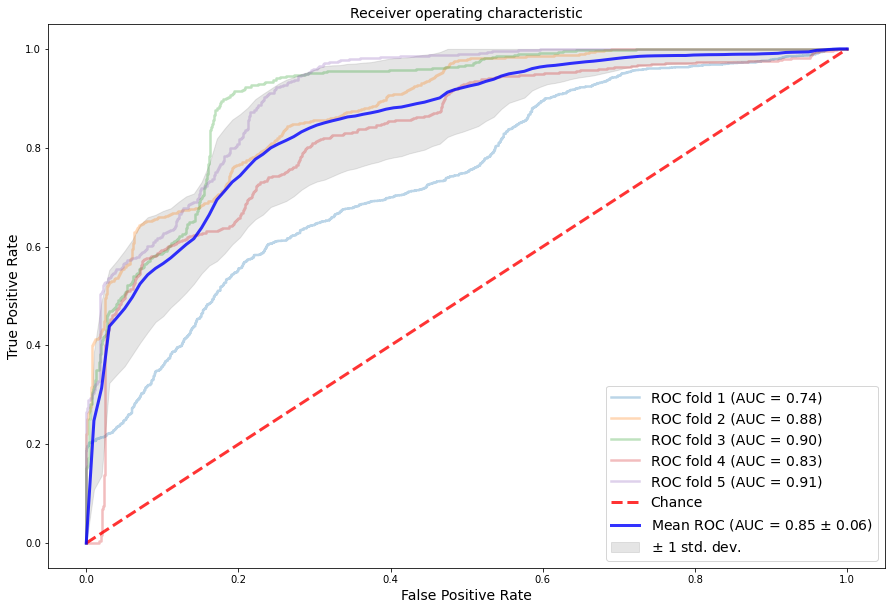

In [6]:
#define some placeholder variables for performance metrics for each fold
results = np.zeros((k,4))#accuracy, AUC, F1 score, Brier  
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
PFIs = np.zeros((k,10))
PFIs_std = np.zeros((k,10))

fig, ax = plt.subplots()
for i in tqdm(range(k)):
    #open
    yTrain = spio.loadmat('yTrain'+str(i+1)+'.mat',squeeze_me = True)
    yTrain = yTrain['yTrain']
    yTest = spio.loadmat('yTest'+str(i+1)+'.mat',squeeze_me = True)
    yTest = yTest['yTest']
    yVal = spio.loadmat('yVal'+str(i+1)+'.mat',squeeze_me = True)
    yVal = yVal['yVal']
    xTrain_transform = pd.read_csv('train_features_custom_'+str(i+1)+'.zip')
    xTest_transform = pd.read_csv('test_features_custom_'+str(i+1)+'.zip')
    xVal_transform = pd.read_csv('val_features_custom_'+str(i+1)+'.zip')
    
    ##add sham variable
    xTrain_transform["sham"]=np.random.rand(len(xTrain_transform),1)
    xTest_transform["sham"]=np.random.rand(len(xTest_transform),1)
    xVal_transform["sham"]=np.random.rand(len(xVal_transform),1)
                  
    #combine training and validation sets for x and y   
    xTrain_transform = pd.concat([xTrain_transform, xVal_transform])
    yTrain = np.concatenate((yTrain, yVal))
    
    xTrain_transform = xTrain_transform.drop(columns=['fio2_mean','fio2_slope','mac_slope','map_slope','hr_mean','cci_mean','spo2_mean'])
    xTest_transform = xTest_transform.drop(columns=['fio2_mean','fio2_slope','mac_slope','map_slope','hr_mean','cci_mean','spo2_mean'])
     
    clf.fit(xTrain_transform,yTrain,eval_metric="error",verbose=False)#, eval_set=eval_set, early_stopping_rounds=50, verbose=False)  
    
    accuracy = clf.score(xTest_transform, yTest)
    probs = clf.predict_proba(xTest_transform)
    auc_k = roc_auc_score(yTest,probs[0:len(probs),1])
    pred = clf.predict(xTest_transform)
    f1 = f1_score(yTest,pred)
    brier_score = brier_score_loss(yTest,probs[0:len(probs),1])
    results[i,]=accuracy,auc_k,f1,brier_score
    
    viz = plot_roc_curve(clf,xTest_transform,yTest,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=2.5, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    #calculate PFI and add to array for averaging 
    perm_importance = permutation_importance(clf, xTest_transform, yTest,n_repeats=100)
    PFIs[i,]=np.array(perm_importance.importances_mean)
    PFIs_std[i,]=np.array(perm_importance.importances_std)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=3, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right")
ax.set_title(label="Receiver operating characteristic",fontsize=14)
plt.xlabel("False Positive Rate",fontsize=14)
plt.ylabel("True Positive Rate",fontsize=14)
fig.set_size_inches(15, 10, forward=True)
plt.legend(prop={'size': 14})
plt.show()

In [7]:
results = pd.DataFrame(results)
results.columns = ['accuracy','auc','f1','brier']
results_summary = pd.DataFrame([results[results.columns].mean().to_numpy(), results[results.columns].std().to_numpy()], columns=results.columns, index=['mean', 'std'])
results_summary

,accuracy,auc,f1,brier
mean,0.770801,0.853577,0.790292,0.178399
std,0.080678,0.071605,0.082528,0.063335


In [8]:
results

,accuracy,auc,f1,brier
0,0.668446,0.738453,0.694034,0.265715
1,0.765592,0.884066,0.748780,0.171239
2,0.834259,0.904683,0.846484,0.134456
3,0.720287,0.830642,0.761190,0.214070
4,0.865422,0.910040,0.900973,0.106519


In [9]:
PFIs = pd.DataFrame(PFIs)
PFIs_std= pd.DataFrame(PFIs_std)
PFIs.columns = xTrain_transform.columns
PFIs_std.columns= xTrain_transform.columns
PFIs_std= pd.DataFrame(PFIs_std)
PFIs_summary = pd.DataFrame([PFIs[PFIs.columns].mean().to_numpy()], columns=PFIs.columns, index=['Relative Mean PFI'])
PFIs_summary.sort_values(by=['Relative Mean PFI'],axis='columns',ascending=True,inplace=True)
divby = float(PFIs_summary.max(axis=1))
PFIs_summary=PFIs_summary.div(divby,axis=1)
PFIs_std=PFIs_std.div(divby,axis=1)

In [10]:
#train model with all data
yTrain = spio.loadmat('yTrain1.mat',squeeze_me = True)
yTrain = yTrain['yTrain']
yTest = spio.loadmat('yTest1.mat',squeeze_me = True)
yTest = yTest['yTest']
yVal = spio.loadmat('yVal1.mat',squeeze_me = True)
yVal = yVal['yVal']
xTrain_transform = pd.read_csv('train_features_custom_1.zip')
xTest_transform = pd.read_csv('test_features_custom_1.zip')
xVal_transform = pd.read_csv('val_features_custom_1.zip')

x = pd.concat([xTrain_transform, xTest_transform, xVal_transform])
x = x.drop(columns=['fio2_mean','fio2_slope','mac_slope','map_slope','hr_mean','cci_mean','spo2_mean'])

#combine training and test sets (using all data to train)
x["sham"]=np.random.rand(len(x),1)

y = np.concatenate((yTrain, yTest, yVal))

clf.fit(x,y,eval_metric="error",verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan,
              monotone_constraints={'cci_slope': -1, 'etco2_mean': -1,
                                    'etco2_slope': -1, 'eto2_mean': -1,
                                    'eto2_slope': -1, 'hr_slope': -1,
                                    'mac_mean': -1, 'map_mean': -1,
                                    'spo2_slope': -1},
              n_estimators=200, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.1, reg_lambda=0.12,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

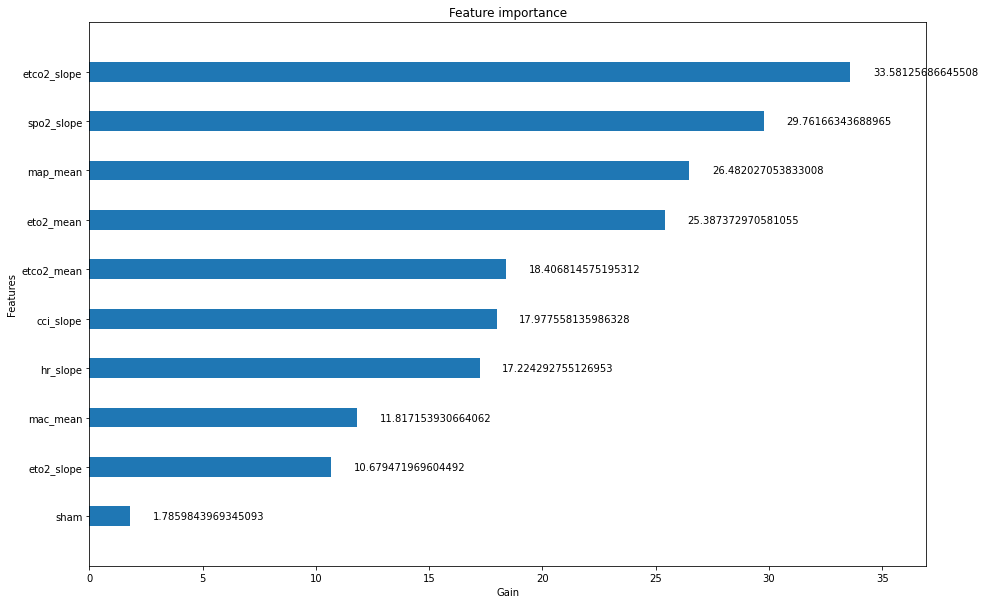

In [11]:
fig, ax = plt.subplots()
xgb.plot_importance(clf, ax=ax, importance_type = 'gain',xlabel='Gain',grid=False,height=0.4,show_values=True)
fig.set_size_inches(15, 10, forward=True)
plt.show()

In [12]:
gainVals = pd.DataFrame(clf.feature_importances_)
gainVals=gainVals.transpose()
gainVals.columns = x.columns
gainVals_summary = pd.DataFrame([gainVals[gainVals.columns].mean().to_numpy()], columns=gainVals.columns, index=['Relative Gain'])
gainVals_summary.sort_values(by=['Relative Gain'],axis='columns',ascending=True,inplace=True)
gainVals_summary=gainVals_summary.div(float(gainVals_summary.max(axis=1)),axis=1)

In [13]:
importancesSummary=gainVals_summary.append(PFIs_summary)
importancesSummary=importancesSummary.append(pd.DataFrame([PFIs_std[PFIs_std.columns].mean().to_numpy()], columns=PFIs_std.columns, index=['PFI Std']))

importancesSummary

,sham,eto2_slope,mac_mean,hr_slope,cci_slope,etco2_mean,eto2_mean,map_mean,spo2_slope,etco2_slope
Relative Gain,0.053184,0.318019,0.351897,0.512914,0.535345,0.548128,0.755998,0.788595,0.886258,1.000000
Relative Mean PFI,0.007441,0.096717,0.133719,0.277288,0.321444,0.198211,0.659012,0.742516,1.000000,0.578859
PFI Std,0.024187,0.026397,0.054042,0.050222,0.048593,0.051239,0.071922,0.069641,0.061178,0.060700


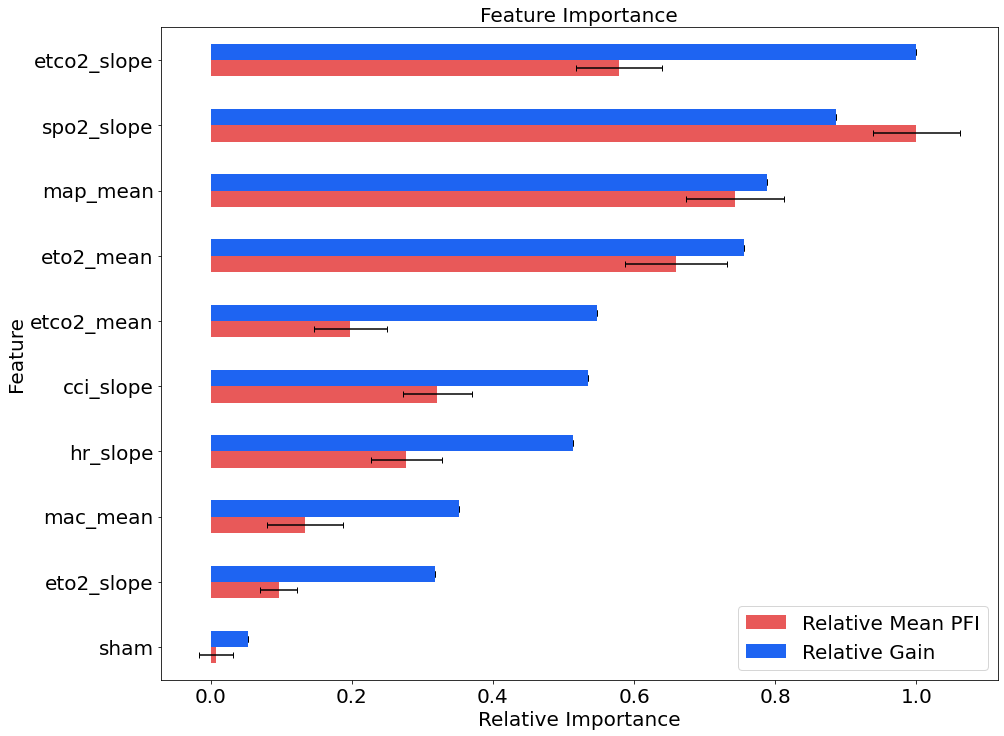

In [15]:
fig, ax = plt.subplots()
importancesSummary.transpose().plot.barh(y=["Relative Mean PFI","Relative Gain"],ax=ax,fontsize=20,color={"Relative Gain": "#1E64F2", "Relative Mean PFI": "#E85959"}, xerr=[importancesSummary.transpose()['PFI Std'],np.zeros(10)], capsize=3)


ax.set_ylabel(ylabel="Feature",fontsize=20)
ax.set_xlabel(xlabel="Relative Importance",fontsize=20)
ax.set_title(label="Feature Importance",fontsize=20)
fig.set_size_inches(15, 12, forward=True)
plt.legend(prop={'size': 20})
plt.show()

Below is old/extra code

In [515]:
xgbfir.saveXgbFI(clf, SortBy ='gain',MaxInteractionDepth =1,MaxHistograms =100,OutputXlsxFile='xgb_rso2_primary.xlsx')

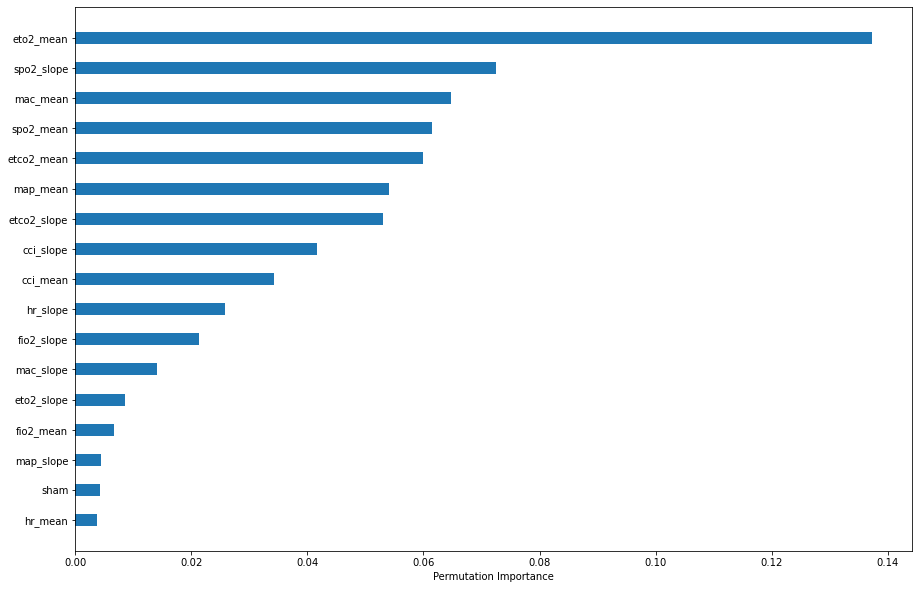

In [14]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(clf, x, y)
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.barh(x.columns[sorted_idx], perm_importance.importances_mean[sorted_idx],height=0.4)
plt.xlabel("Permutation Importance")
fig.set_size_inches(15, 10, forward=True)
plt.show()

In [187]:
perm_importance.importances_mean[sorted_idx]

array([0.00922115, 0.0448728 , 0.0509855 , 0.06873318, 0.08029869,
       0.08444908, 0.10256143, 0.11544673, 0.11867674, 0.16599809])

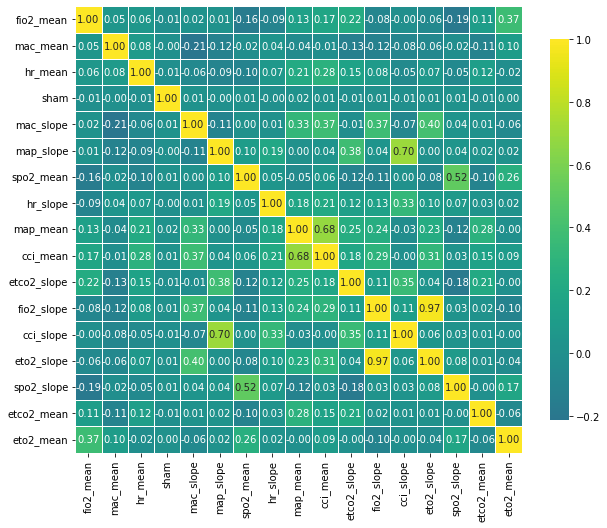

In [264]:
import seaborn as sns
def correlation_heatmap(x):
    correlations = x.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="viridis",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(x[x.columns[sorted_idx]])
